In [2]:
import numpy as np 
import pandas as pd 
import os
import sys
sys.path.append('/home/lucas/Documents/Log_Analysis')
import analog
from analog import logextract as logextract
import datetime
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
log_path = '/home/lucas/Documents/Log_Analysis/Battery'
print(os.listdir(log_path))
file1 = f'{log_path}/2019-09-06_1_LiHV - Discharge-part1.csv'
file2 = f'{log_path}/2019-09-06_1_LiHV - Discharge-part2.csv'
file3 = f'{log_path}/2019-09-09_1_LiHV - Discharge-part3.csv'

['resistancetestz0.ulg', 'Battery Simulation.ipynb', 'Equivalent Circuit Parameters Estimation-z0.ipynb', 'Static parameters estimation.ipynb', 'SOCvsOCV.csv', 'log_297_2019-9-3-15-14-02.ulg', 'log_296_2019-9-3-15-11-56.ulg', 'motor_test_compressed.txt', 'Rough EC Dynamic Params Estimation.ipynb', '.ipynb_checkpoints', 'log_299_2019-9-3-15-22-14.ulg', '2019-09-09_1_LiHV - Discharge-part3.csv', 'battery_test_compressed.txt', 'motor_test.log', '2019-09-06_1_LiHV - Discharge-part1.csv', 'battery.py', 'SOC estimator couloumb counting.ipynb', 'EC dynamic parameters estimation.ipynb', 'log_298_2019-9-3-15-24-50.ulg', '2019-09-06_1_LiHV - Discharge-part2.csv', 'log_295_2019-9-3-15-07-46.ulg', 'Q200', '__pycache__', 'battery_test.log', 'ECparam optimizer.ipynb', 'ECparams.csv']


In [4]:
df1 = pd.read_csv(file1, sep=';', decimal=',', header=1,engine='python')
df2 = pd.read_csv(file2, sep=';', decimal=',', header=1,engine='python')
df3 = pd.read_csv(file3, sep=';', decimal=',', header=1,engine='python')
print(df3.columns)

Index(['Time [hh:mm:ss.SSS]', 'Voltage [V]', 'Current [A]', 'Capacity [mAh]',
       'Power [W]', 'Temperature Int [�C]', 'BatteryRi [m?]', 'Balance [mV]',
       'CellVoltage 1 [V]', 'CellVoltage 2 [V]', 'CellVoltage 3 [V]',
       'CellVoltage 4 [V]'],
      dtype='object')


In [5]:
time1 = df1['Time [hh:mm:ss.SSS]']
time2 = df2['Time [hh:mm:ss.SSS]']
time3 = df3['Time [hh:mm:ss.SSS]']
cell_voltage1 = df1['CellVoltage 1 [V]']
cell_voltage2 = df2['CellVoltage 1 [V]']
cell_voltage3 = df3['CellVoltage 1 [V]']
current1 = df1['Current [A]']
current2 = df2['Current [A]']
current3 = df3['Current [A]']
print(current1)

0       0.06
1       0.10
2       0.16
3       0.23
4       0.29
        ... 
7192    0.43
7193    0.50
7194    0.56
7195    0.61
7196    0.61
Name: Current [A], Length: 7197, dtype: float64


In [6]:
timelist1 = []
stime1 = []
for k in range(len(time1)):
    time = datetime.datetime.strptime(time1[k],'             %H:%M:%S,000')
    timelist1.append(time)
    timedelta = time - timelist1[0]
    stime1.append(float(timedelta.total_seconds()))

In [25]:
timelist2= []
stime2= []
for k in range(len(time2)):
    time = datetime.datetime.strptime(time2[k],'             %H:%M:%S,000')
    timelist2.append(time)
    timedelta = time - timelist2[0]
    stime2.append((timedelta.total_seconds()))

In [26]:
timelist3= []
stime3= []
for k in range(len(time3)):
    time = datetime.datetime.strptime(time3[k],'             %H:%M:%S,000')
    timelist3.append(time)
    timedelta = time - timelist3[0]
    stime3.append((timedelta.total_seconds()))

In [27]:
for k in range(len(stime2)):
    stime2[k] += stime1[-1] + 1.0
for k in range(len(stime3)):
    stime3[k] += stime2[-1] + 1.0
    
print(stime1[-1])
print(stime2[0])

print(stime2[-1])
print(stime3[0])

7196.0
7197.0
21281.0
21282.0


In [28]:
stime = stime1 + stime2 + stime3 # concatenation of three lists
values,unibool = np.unique(stime,return_counts=True)
print(np.all(unibool)) # should be True for no overlap
print(len(stime))
current = current1.append(current2) # concatenation of two pandas series
current = current.append(current3)
cell_voltage = cell_voltage1.append(cell_voltage2)
cell_voltage = cell_voltage.append(cell_voltage3)

True
38265


In [29]:
dt1 = np.diff(stime1)
dt2 = np.diff(stime2)
dt3 = np.diff(stime3)
dt = np.diff(stime)

print(np.mean(dt2))

1.0


In [48]:
dq1 = current1[1:]*dt1
dq2 = current2[1:]*dt2
dq3 = current3[1:]*dt3
dq = current[1:]*dt
Qtot = np.sum(dq)

print(f'Total capacity is {Qtot/3.6} mAh')

z1 = 1-np.cumsum(dq1)/Qtot
z2 = z1.iloc[-1]-np.cumsum(dq2)/Qtot
z = 1 - np.cumsum(dq)/Qtot

Total capacity is 6671.874999999999 mAh


<IPython.core.display.Javascript object>


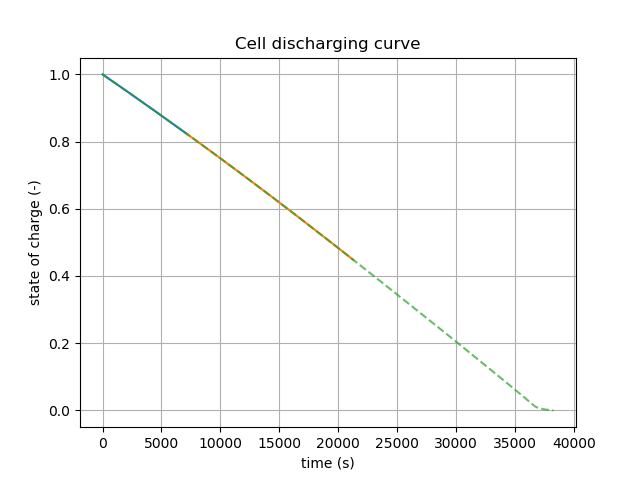

In [49]:
plt.figure()
plt.plot(stime1[1:],z1)
plt.plot(stime2[1:],z2)
plt.plot(stime[1:],z,alpha=0.7,linestyle='--')
plt.xlabel('time (s)')
plt.ylabel('state of charge (-)')
plt.title('Cell discharging curve')
plt.grid()

<IPython.core.display.Javascript object>


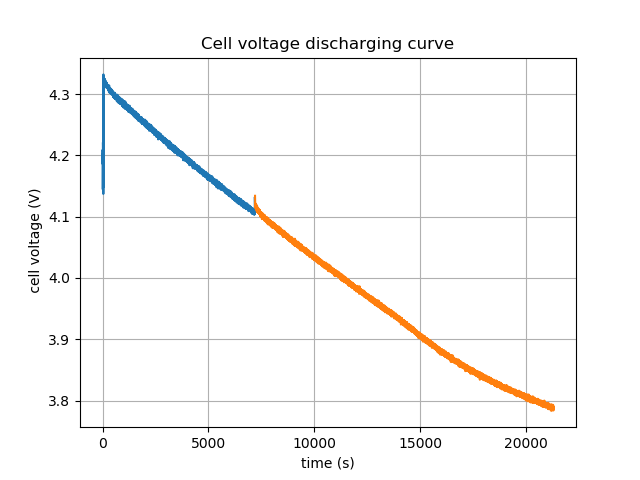

In [40]:
plt.figure()
plt.plot(stime1,cell_voltage1)
plt.plot(stime2,cell_voltage2)
plt.xlabel('time (s)')
plt.ylabel(' cell voltage (V)')
plt.title('Cell voltage discharging curve')
plt.grid()

<IPython.core.display.Javascript object>


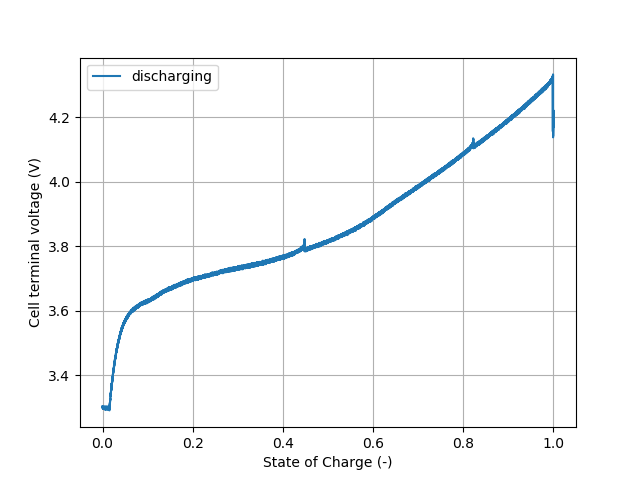

Text(0, 0.5, 'Cell terminal voltage (V)')

In [50]:
plt.figure()
plt.plot(z,cell_voltage[1:],label='discharging')
plt.legend()
plt.grid()
plt.xlabel('State of Charge (-)')
plt.ylabel('Cell terminal voltage (V)')

In [44]:
R0 = 0.0123
OCV = cell_voltage + current*R0

In [56]:
p = np.polyfit(z,OCV[1:],11)
#p = np.polyfit(z[:-2000],OCV[:-2001],11)
print(z.iloc[-1500])

0.010666666667026092


<IPython.core.display.Javascript object>


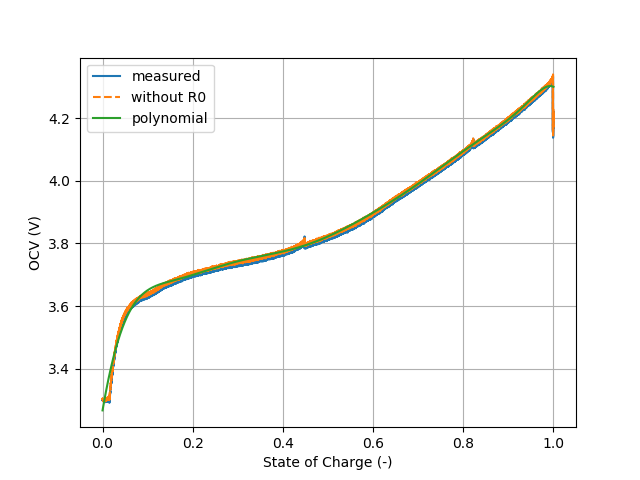

Text(0, 0.5, 'OCV (V)')

In [57]:
plt.figure()
plt.plot(z,cell_voltage[1:],label='measured')
plt.plot(z,OCV[1:],linestyle='--',label='without R0')
plt.plot(z,np.polyval(p,z),label='polynomial')
plt.legend()
plt.grid()
plt.xlabel('State of Charge (-)')
plt.ylabel('OCV (V)')

In [58]:
import csv 
csv_file = open('SOCvsOCV.csv','w')
writer = csv.writer(csv_file)
writer.writerow(['SOC','OCV'])
for k in range(len(z)):
    writer.writerow([z.values[k],np.polyval(p,z.values[k])])